In [1]:
## code reference 1: https://github.com/andreoniriccardo/CNN-from-scratch/tree/main
## code reference 2: https://towardsdatascience.com/building-a-convolutional-neural-network-from-scratch-using-numpy-a22808a00a40

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf ## for loading dataset

2023-09-28 19:01:40.539380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 19:01:40.578661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 19:01:40.579461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 19:01:41.374661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load training data from MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

## choose 3000 samples as the training set
X_train = X_train[:3000]
y_train = y_train[:3000]

## choose 500 samples as the validation test
X_test = X_test[:500]
y_test = y_test[:500]

In [4]:
X_train.shape, X_test.shape

((3000, 28, 28), (500, 28, 28))

## build CNN from scratch 

In [5]:
## conv layer
class ConvolutionLayer:
    def __init__(self, kernel_num, kernel_size):
        """
        Constructor takes as input the number of kernels and their size. I assume only squared filters of size kernel_size x kernel_size
        """
        ## the number of filters
        self.kernel_num = kernel_num
        ## size of filters
        self.kernel_size = kernel_size
        
        # Generate random filters of shape (kernel_num, kernel_size, kernel_size). 
        # Divide by kernel_size^2 for weight normalization
        self.kernels = np.random.randn(kernel_num, kernel_size, kernel_size) / (kernel_size**2)

    def patches_generator(self, image):
        """
        Divide the input image in patches to be used during convolution.
        Yields the tuples containing the patches and their coordinates.
        """
        # Extract image height and width
        image_h, image_w = image.shape
        self.image = image
        
        # The number of patches, given a fxf filter is h-f+1 for height and w-f+1 for width
        for h in range(image_h-self.kernel_size+1):
            for w in range(image_w-self.kernel_size+1):
                patch = image[h:(h+self.kernel_size), w:(w+self.kernel_size)]
                yield patch, h, w
    
    def forward_prop(self, image):
        """
        Perform forward propagation for the convolutional layer.
        """
        # Extract image height and width
        image_h, image_w = image.shape
        
        # Initialize the shape of the output after convolution
        convolution_output = np.zeros((image_h-self.kernel_size+1, image_w-self.kernel_size+1, self.kernel_num))
        # Unpack the generator
        for patch, h, w in self.patches_generator(image):
            # Perform convolution for each patch
            convolution_output[h,w] = np.sum(patch*self.kernels, axis=(1,2))
        return convolution_output
    
    def back_prop(self, dE_dY, alpha):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically max pooling layer.
        It updates the kernels' weights
        """
        # Initialize gradient of the loss function with respect to the kernel weights
        dE_dk = np.zeros(self.kernels.shape)
        for patch, h, w in self.patches_generator(self.image):
            for f in range(self.kernel_num):
                dE_dk[f] += patch * dE_dY[h, w, f]
        # Update the filters
        self.kernels -= alpha*dE_dk
        return dE_dk

In [6]:
## pooling layer
## the task of the pooling layer is to shrink the input image, which can reduce the number of parameters.
class MaxPoolingLayer:
    def __init__(self, kernel_size):
        """
        Constructor takes as input the size of the kernel
        """
        ## the shape of filters
        self.kernel_size = kernel_size

    def patches_generator(self, image):
        """
        Divide the input image in patches to be used during pooling.
        Yields the tuples containing the patches and their coordinates.
        """
        # the shape of output after the pooling
        output_h = image.shape[0] // self.kernel_size
        output_w = image.shape[1] // self.kernel_size
        self.image = image
        
        # yield the portions of the images on which to performn each convolution step
        for h in range(output_h):
            for w in range(output_w):
                patch = image[(h*self.kernel_size):(h*self.kernel_size+self.kernel_size), (w*self.kernel_size):(w*self.kernel_size+self.kernel_size)]
                yield patch, h, w

    def forward_prop(self, image):
        image_h, image_w, num_kernels = image.shape  ## (row, column, # of filters)
        
        # the shape of the output after pooling
        max_pooling_output = np.zeros((image_h//self.kernel_size, image_w//self.kernel_size, num_kernels))
        
        ## for each pacth, choose the max value in this patch as the value 
        for patch, h, w in self.patches_generator(image):
            max_pooling_output[h,w] = np.amax(patch, axis=(0,1))
        return max_pooling_output

    def back_prop(self, dE_dY):
        """
        Takes the gradient of the loss function with respect to the output and computes the gradients of the loss function with respect
        to the kernels' weights.
        dE_dY comes from the following layer, typically softmax.
        There are no weights to update, but the output is needed to update the weights of the convolutional layer.
        """
        dE_dk = np.zeros(self.image.shape)
        for patch,h,w in self.patches_generator(self.image):
            image_h, image_w, num_kernels = patch.shape
            max_val = np.amax(patch, axis=(0,1))

            for idx_h in range(image_h):
                for idx_w in range(image_w):
                    for idx_k in range(num_kernels):
                        if patch[idx_h,idx_w,idx_k] == max_val[idx_k]:
                            dE_dk[h*self.kernel_size+idx_h, w*self.kernel_size+idx_w, idx_k] = dE_dY[h,w,idx_k]
        return dE_dk

In [7]:
## softmax layer
class SoftmaxLayer:
    """
    Takes the volume coming from convolutional & pooling layers. It flattens it and it uses it in the next layers.
    """
    def __init__(self, input_units, output_units):
        # Initiallize weights and biases
        self.weight = np.random.randn(input_units, output_units)/input_units
        self.bias = np.zeros(output_units)

    ## forward process
    def forward_prop(self, image):
        self.original_shape = image.shape # stored for backprop
        
        # Flatten the image
        image_flattened = image.flatten()
        self.flattened_input = image_flattened # stored for backprop
        
        # linear
        first_output = np.dot(image_flattened, self.weight) + self.bias
        self.output = first_output
        
        # softmax activation function
        softmax_output = np.exp(first_output) / np.sum(np.exp(first_output), axis=0)
        return softmax_output

    ## back propogation
    def back_prop(self, dE_dY, alpha):
        for i, gradient in enumerate(dE_dY):
            if gradient == 0:
                continue
            transformation_eq = np.exp(self.output)
            S_total = np.sum(transformation_eq)

            # Compute gradients with respect to output (Z)
            # dy/dz
            dY_dZ = -transformation_eq[i]*transformation_eq / (S_total**2)
            dY_dZ[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total**2)

            # Compute gradients of output Z with respect to weight, bias, input. 
            # dz/dw, dz/db, dz/dx
            dZ_dw = self.flattened_input
            dZ_db = 1
            dZ_dX = self.weight

            # Gradient of loss with respect ot output
            dE_dZ = gradient * dY_dZ

            # Gradient of loss with respect to weight, bias, input
            dE_dw = dZ_dw[np.newaxis].T @ dE_dZ[np.newaxis]
            dE_db = dE_dZ * dZ_db
            dE_dX = dZ_dX @ dE_dZ

            # Update parameters
            # weight = weight - alpha*de/dw
            # bias = bias - alpha*de/db
            self.weight -= alpha*dE_dw
            self.bias -= alpha*dE_db

            return dE_dX.reshape(self.original_shape)


In [8]:
## forward and backporpagation
def CNN_forward(image, label, layers):
    ## pixel value from 0-255 to 0-1
    output = image/255.
    
    # forward
    for layer in layers:
        output = layer.forward_prop(output)
    
    # Compute loss (cross-entropy) and accuracy
    loss = -np.log(output[label])
    accuracy = 1 if np.argmax(output) == label else 0
    
    return output, loss, accuracy

def CNN_backprop(gradient, layers, alpha=0.05):
    grad_back = gradient
    
    ## from the last layer to the first layer
    for layer in layers[::-1]:
        if type(layer) in [ConvolutionLayer, SoftmaxLayer]:
            grad_back = layer.back_prop(grad_back, alpha)
        elif type(layer) == MaxPoolingLayer:
            grad_back = layer.back_prop(grad_back)
    return grad_back

In [9]:
## training process

def CNN_training(image, label, layers, alpha=0.001):
    # Forward step
    output, loss, accuracy = CNN_forward(image, label, layers)

    # Initial gradient
    gradient = np.zeros(10)
    gradient[label] = -1/output[label]

    # Backprop step
    gradient_back = CNN_backprop(gradient, layers, alpha)

    return loss, accuracy

In [10]:
## Add a validation process
def CNN_valid(image, label, layers):
    # only contain forward step
    output, loss, accuracy = CNN_forward(image, label, layers)

    return loss, accuracy

In [12]:
# Define the network
# since filters size is 3x3 and input size is 28x28, so the output of the convolutional layer is 26x26  (28-3+1)
layers = [
    ConvolutionLayer(16,3), # layer with 16 3x3 filters, output (26,26,16)
    MaxPoolingLayer(2), # pooling layer 2x2, output (26/2, 26/2, 16)
    SoftmaxLayer(13*13*16, 10) # softmax layer with 13*13*16 input and 10 output
    ] 

train_loss_total = []
valid_los_total = []
## set 15 epochs 
for epoch in range(15):
    #print('Epoch {} ->'.format(epoch+1))
    
    # Shuffle training data
    permutation = np.random.permutation(len(X_train))
    X_train = X_train[permutation]
    y_train = y_train[permutation]
    
    # Training the CNN
    loss = 0
    accuracy = 0
    for i, (image, label) in enumerate(zip(X_train, y_train)):
        if i % 500 == 0: # Every 100 examples
            print("Step {}. For the last 500 steps: average loss {}, accuracy {}".format(i+1, loss/500, accuracy/500))
            loss = 0
            accuracy = 0
        loss_1, accuracy_1 = CNN_training(image, label, layers)
        loss += loss_1
        accuracy += accuracy_1
        
        
    ## Add a valid process, and then we can show the loss curve
    loss_val = 0
    accuracy_val = 0
    for i, (image, label) in enumerate(zip(X_test, y_test)):
        loss_2, accuracy_2 = CNN_training(image, label, layers)
        loss_val += loss_2
        accuracy_val += accuracy_2
        
    ep_loss_train = loss/len(y_train)    
    ep_loss_val = loss_val/len(y_test)
    
    train_loss_total.append(ep_loss_train)
    valid_los_total.append(ep_loss_val)
    print("Epoch {}: Training loss {}, Valid loss {}, Training accuracy {}, Valid accuracy {}".format(epoch+1, ep_loss_train, accuracy/len(y_train), loss_val/len(y_test), ep_loss_val))

Step 1. For the last 500 steps: average loss 0.0, accuracy 0.0
Step 501. For the last 500 steps: average loss 2.1522890524614615, accuracy 0.398
Step 1001. For the last 500 steps: average loss 1.7140629411385266, accuracy 0.694
Step 1501. For the last 500 steps: average loss 1.1373485097796012, accuracy 0.776
Step 2001. For the last 500 steps: average loss 0.8409783946106144, accuracy 0.798
Step 2501. For the last 500 steps: average loss 0.6684464226228302, accuracy 0.852
Epoch 1: Training loss 0.09860305292244678, Valid loss 0.14033333333333334, Training accuracy 0.5705851704142173, Valid accuracy 0.5705851704142173
Step 1. For the last 500 steps: average loss 0.0, accuracy 0.0
Step 501. For the last 500 steps: average loss 0.47922016721249205, accuracy 0.854
Step 1001. For the last 500 steps: average loss 0.45093763602492476, accuracy 0.876
Step 1501. For the last 500 steps: average loss 0.41497322097793166, accuracy 0.874
Step 2001. For the last 500 steps: average loss 0.35883295580

Step 1001. For the last 500 steps: average loss 0.25699584978608486, accuracy 0.922
Step 1501. For the last 500 steps: average loss 0.18800173462362016, accuracy 0.946
Step 2001. For the last 500 steps: average loss 0.25850378092854887, accuracy 0.932
Step 2501. For the last 500 steps: average loss 0.205976056332583, accuracy 0.94
Epoch 14: Training loss 0.04118274911097427, Valid loss 0.15466666666666667, Training accuracy 0.20651834839792493, Valid accuracy 0.20651834839792493
Step 1. For the last 500 steps: average loss 0.0, accuracy 0.0
Step 501. For the last 500 steps: average loss 0.19433224100349772, accuracy 0.94
Step 1001. For the last 500 steps: average loss 0.1990224730508276, accuracy 0.948
Step 1501. For the last 500 steps: average loss 0.2542937225881802, accuracy 0.912
Step 2001. For the last 500 steps: average loss 0.2716883563581379, accuracy 0.914
Step 2501. For the last 500 steps: average loss 0.18865667548759518, accuracy 0.944
Epoch 15: Training loss 0.029926227958

## plot loss curve

In [13]:
import matplotlib.pyplot as plt

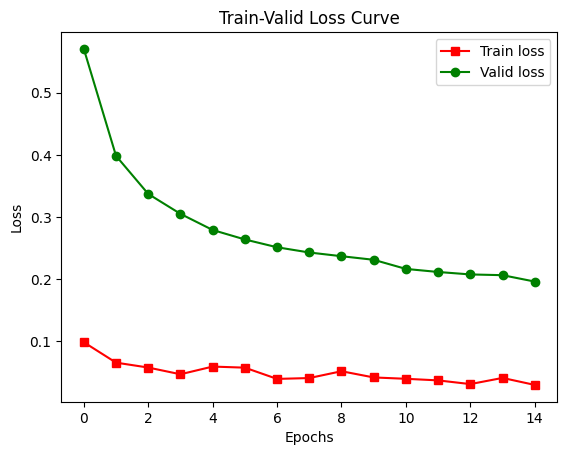

In [15]:
## plot loss cruve
import matplotlib.pyplot as plt

idx_list = list(range(len(valid_los_total)))

#fig = plt.figure()
plt.plot(idx_list,train_loss_total,'s-',color = 'r',label="Train loss")  # train curve
plt.plot(idx_list,valid_los_total,'o-',color = 'g',label="Valid loss")  # validation curve
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend() 
plt.title("Train-Valid Loss Curve")
#plt.savefig("Q5_loss_curve")
plt.show()